# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

In [2]:
geo_data = pd.read_excel('geo.xlsx')

In [3]:
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108806 entries, 0 to 108805
Data columns (total 3 columns):
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB


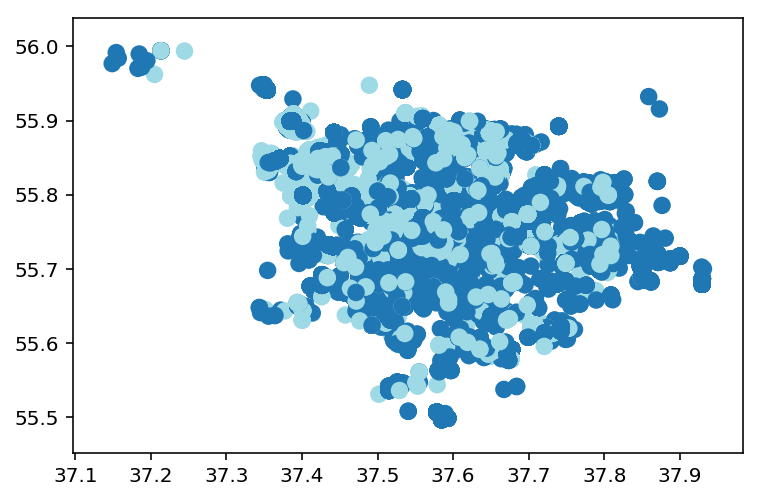

In [4]:
plt.scatter(geo_data.x, geo_data.y, c=geo_data.comment_class, cmap='tab20', s=60)

Кластеризация:

In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [6]:
algorithms = [
    AffinityPropagation(),
    KMeans(n_clusters=15),
    AgglomerativeClustering(n_clusters=15),
    DBSCAN(),
]

Уберем повторы, в gdd останутся все голоса, и "за", и "против". 
После этого выделим в voted_yes координаты, где проголосовали "за" и в voted_no - "против". 
После этого уберем из gdd столбец с голосами, оставим только координаты.

In [7]:
gdd = geo_data.drop_duplicates(subset=['x', 'y']).copy()

voted_yes = gdd[gdd.comment_class == 1].copy()
voted_yes.drop("comment_class", axis=1, inplace=True)

voted_no = gdd[gdd.comment_class == -1].copy()
voted_no.drop("comment_class", axis=1, inplace=True)

gdd.drop("comment_class", axis=1, inplace=True)

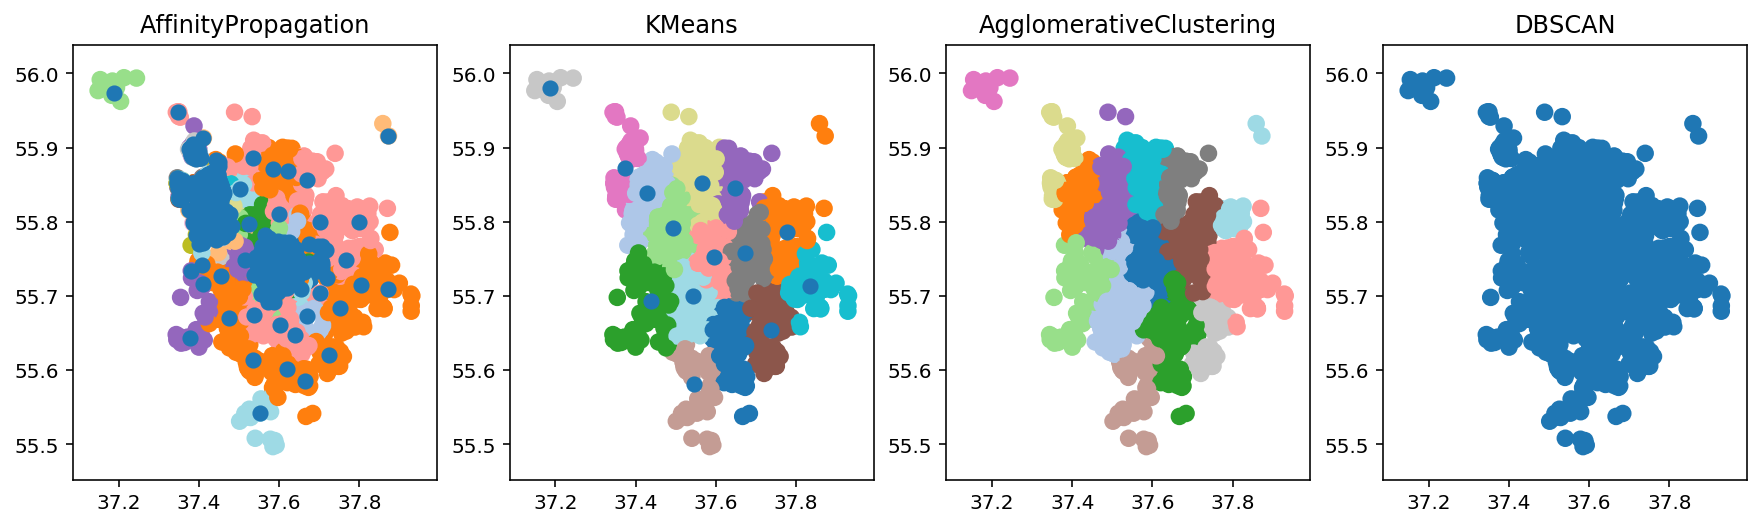

In [8]:
fig, axes = plt.subplots(1, len(algorithms) , figsize=(15, 4))

for ax, algorithm in zip(axes, algorithms):
    # кластеризуем и выводим картинку
    cluster = algorithm.fit_predict(gdd)
    ax.scatter(gdd.x, gdd.y, c=cluster, cmap='tab20', s=60)
    ax.set_title(algorithm.__class__.__name__)
  
    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

Лучше всего сработал алгоритм AgglomerativeClustering, на нем покажем кластеризацию голосов "за" и "против"

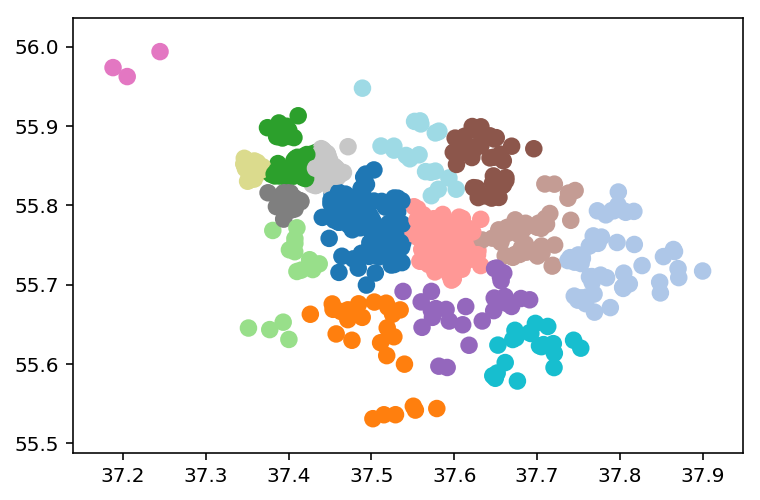

In [9]:
clf = AgglomerativeClustering(15)
cluster = clf.fit_predict(voted_yes)
plt.clf()
plt.scatter(voted_yes.x, voted_yes.y, c=cluster, cmap='tab20', s=60)
plt.show()

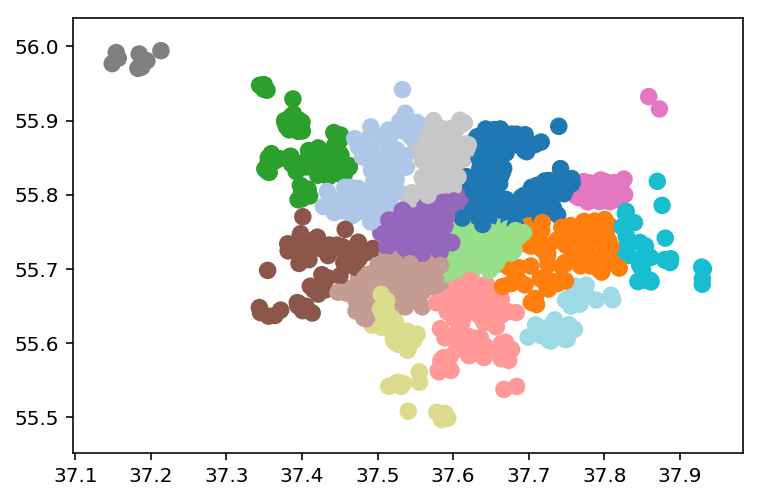

In [10]:
clf = AgglomerativeClustering(15)
cluster = clf.fit_predict(voted_no)
plt.clf()
plt.scatter(voted_no.x, voted_no.y, c=cluster, cmap='tab20', s=60)
plt.show()

In [11]:
k_inertia = []
ks = range(1,30)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(gdd, )
    k_inertia.append(clf_kmeans.inertia_)

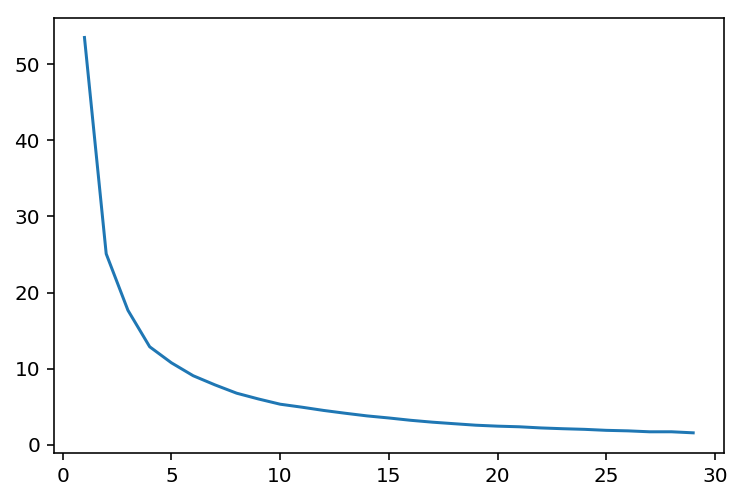

In [12]:
plt.plot(ks, k_inertia)

In [13]:
diff = np.diff(k_inertia)

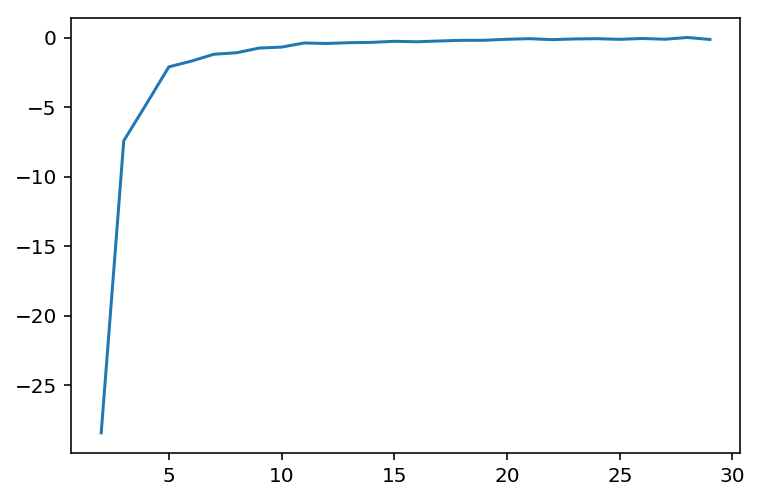

In [14]:
plt.plot(ks[1:], diff)

In [15]:
diff_r = diff[1:] / diff[:-1]

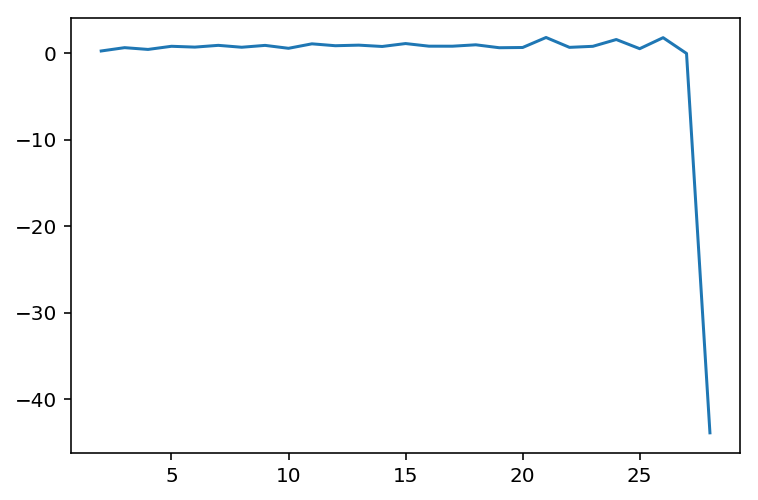

In [16]:
plt.plot(ks[1:-1], diff_r)

In [17]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

28